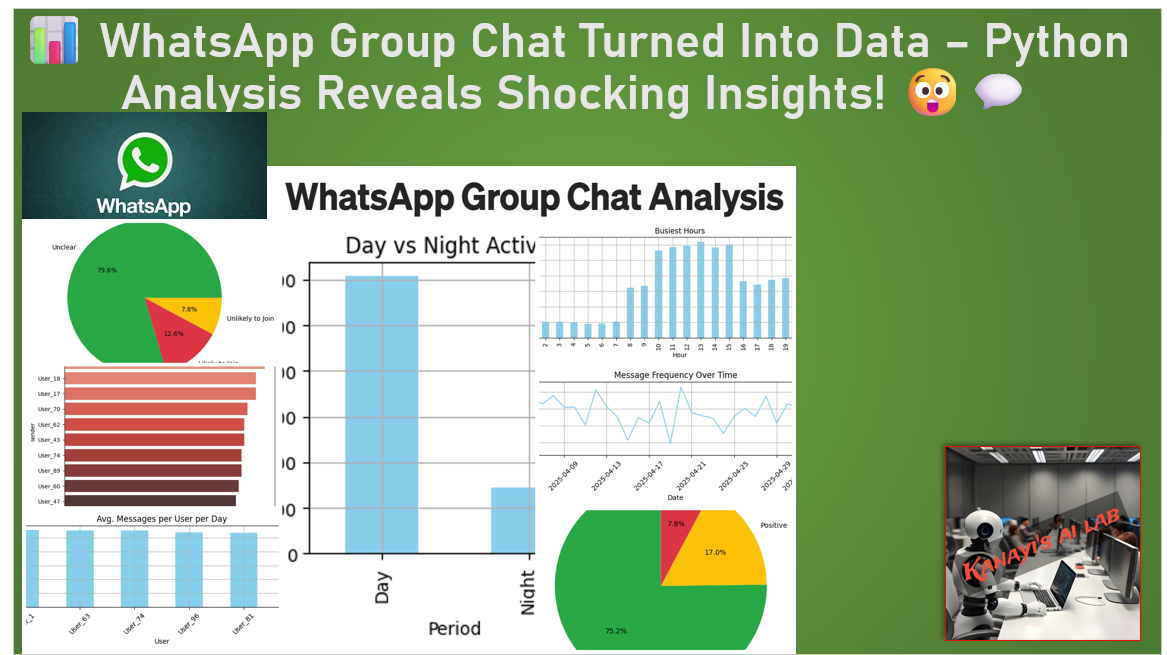

**Steps to Export the chart from Whatsapp Group**

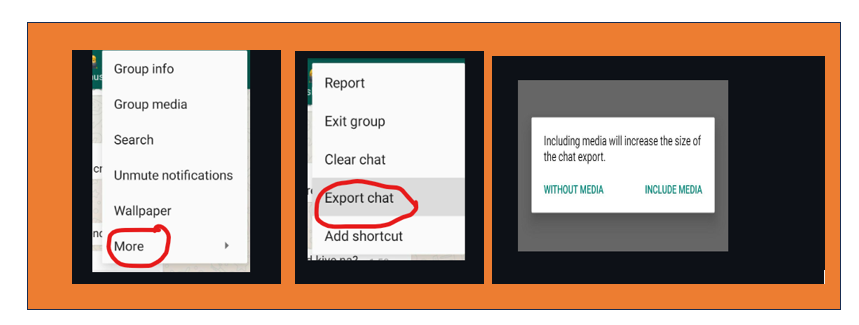

***Setup***

In [1]:
# Install required libraries
#pip install textblob

# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob
from wordcloud import WordCloud
from datetime import datetime


**Load & Parse Chat Data**

In [2]:
# prompt: mount collab drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Load and parse the chat file
with open("/content/drive/MyDrive/Whatsapp Data Analysis/synthetic_whatsapp_chat_reunion_updated.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

pattern = r"\[(.*?)\] (.*?): (.*)"
data = []

for line in lines:
    match = re.match(pattern, line)
    if match:
        timestamp_str, sender, message = match.groups()
        try:
            timestamp = datetime.strptime(timestamp_str, "%d/%m/%Y, %H:%M:%S")
            data.append([timestamp, sender, message])
        except ValueError:
            continue

df = pd.DataFrame(data, columns=["timestamp", "sender", "message"])
df.head(2)

,timestamp,sender,message
0,2025-04-01 00:12:06,User_67,This feels like old times again 😊
1,2025-04-01 00:19:20,User_53,"@User_17, Love the energy in this group ❤️"


**Add Time-Based Columns**

In [4]:
df["date"] = df["timestamp"].dt.date
df["hour"] = df["timestamp"].dt.hour
df["weekday"] = df["timestamp"].dt.weekday
df["period"] = df["hour"].apply(lambda x: "Day" if 8 <= x <= 20 else "Night")
df["day_type"] = df["weekday"].apply(lambda x: "Weekday" if x < 5 else "Weekend")
df.head(2)

,timestamp,sender,message,date,hour,weekday,period,day_type
0,2025-04-01 00:12:06,User_67,This feels like old times again 😊,2025-04-01,0,1,Night,Weekday
1,2025-04-01 00:19:20,User_53,"@User_17, Love the energy in this group ❤️",2025-04-01,0,1,Night,Weekday


***1. Top 3 most active participants in our WhatsApp group chat reunion ?***





In [5]:
print(df["sender"].value_counts().head(3))

sender
User_57    212
User_63    210
User_62    206
Name: count, dtype: int64


***2. how did the group’s activity change over time ?***

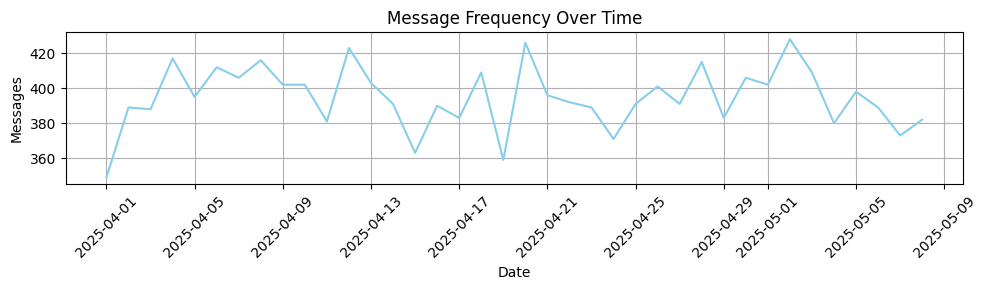

In [6]:
df.groupby("date").size().plot(kind='line', title='Message Frequency Over Time', figsize=(10, 3), color="skyblue")
plt.xlabel("Date"); plt.ylabel("Messages"); plt.grid(True); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

***3. What were the busiest hours in our WhatsApp group?***

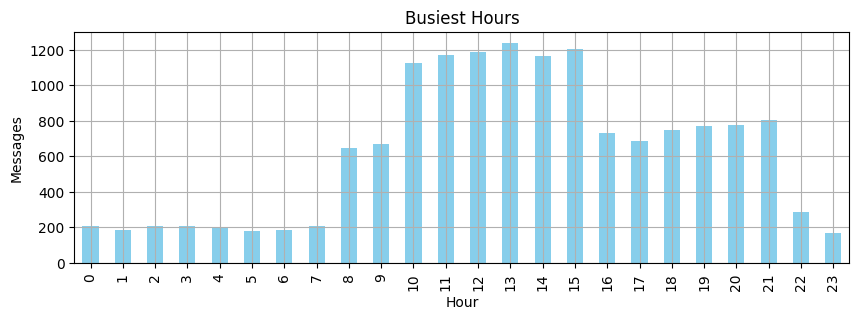

In [7]:
df.groupby("hour").size().plot(kind='bar', title="Busiest Hours", figsize=(10, 3), color="skyblue")
plt.xlabel("Hour"); plt.ylabel("Messages"); plt.grid(True); plt.show()

***4. How does activity in our WhatsApp group compare between day and night?***

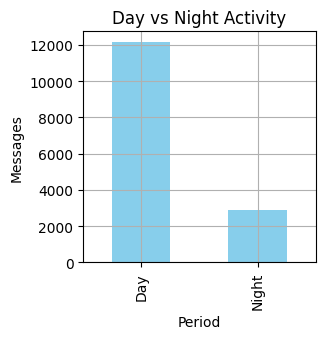

In [8]:
df["period"].value_counts().plot(kind='bar', title="Day vs Night Activity", figsize=(3, 3), color="skyblue")
plt.xlabel("Period"); plt.ylabel("Messages"); plt.grid(True); plt.show()

***5. How does the activity in our WhatsApp group differ between weekdays and weekends?***

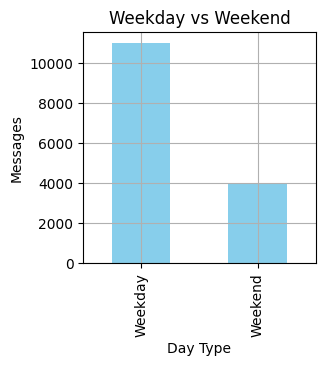

In [9]:
df["day_type"].value_counts().plot(kind='bar', title="Weekday vs Weekend", figsize=(3, 3), color="skyblue")
plt.xlabel("Day Type"); plt.ylabel("Messages"); plt.grid(True); plt.show()

***6. Which users sent the most average messages per day in the group?***

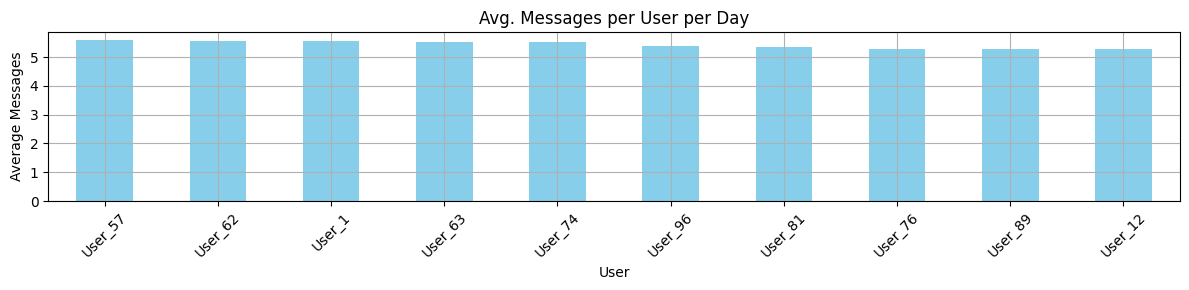

In [9]:
avg_msgs = df.groupby(["sender", "date"]).size().groupby("sender").mean().sort_values(ascending=False)
avg_msgs.head(10).plot(kind='bar', title="Avg. Messages per User per Day", figsize=(12, 3), color="skyblue")
plt.xlabel("User"); plt.ylabel("Average Messages"); plt.grid(True); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

***7. Which users sent the most negative messages in the group?***

<ipython-input-10-a13ec4402bca>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=neg_users.values, y=neg_users.index, palette="Reds_d")


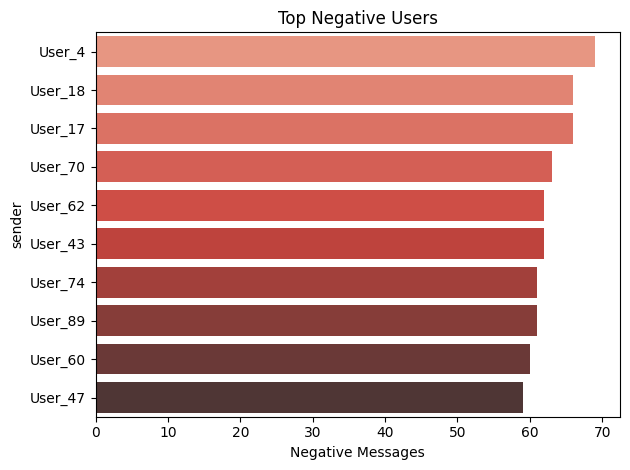

In [10]:
neg_keywords = ["not", "no", "out", "waste", "bad", "mess", "sorry"]
df["is_negative"] = df["message"].apply(lambda x: any(word in x.lower() for word in neg_keywords))
neg_users = df[df["is_negative"]]["sender"].value_counts().head(10)

sns.barplot(x=neg_users.values, y=neg_users.index, palette="Reds_d")
plt.title("Top Negative Users"); plt.xlabel("Negative Messages"); plt.tight_layout(); plt.show()

***8.What are the most common words in the group chat?***

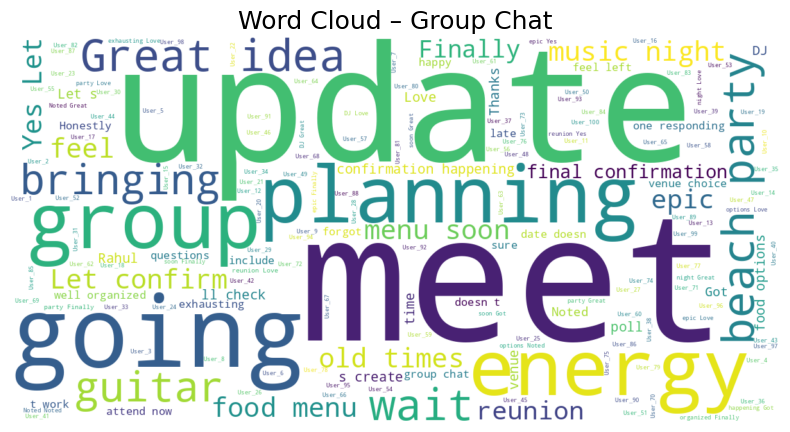

In [11]:
text = " ".join(df["message"].dropna())
wordcloud = WordCloud(width=1200, height=600, background_color="white").generate(text)

plt.figure(figsize=(12, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – Group Chat", fontsize=18)
plt.show()

***9.Based on sentiment, what is the intent of users to join the group?***

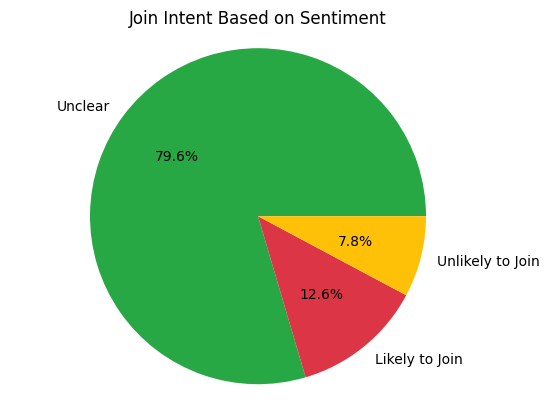

In [12]:
def classify_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    return "Likely to Join" if polarity > 0.2 else "Unlikely to Join" if polarity < -0.1 else "Unclear"

user_comments = df.copy()
user_comments["sentiment_score"] = user_comments["message"].apply(lambda x: TextBlob(x).sentiment.polarity)
user_comments["join_intent"] = user_comments["message"].apply(classify_sentiment)

# Pie Chart
intent_counts = user_comments["join_intent"].value_counts()
plt.pie(intent_counts, labels=intent_counts.index, autopct="%1.1f%%", colors=["#28a745", "#dc3545", "#ffc107"])
plt.title("Join Intent Based on Sentiment")
plt.axis("equal")
plt.show()

***10.How does sentiment analysis influence users' intent to join the group?***

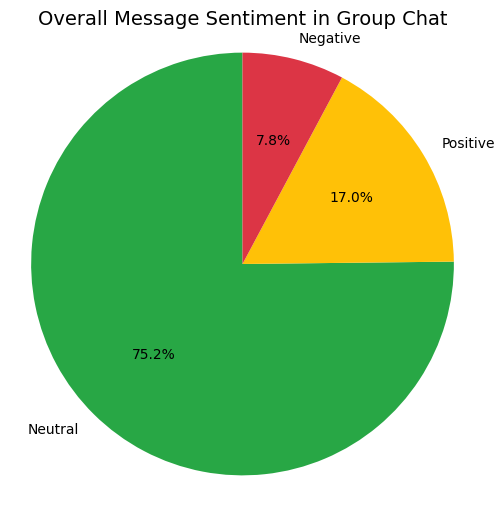

In [13]:
# Function to classify individual message sentiment
def message_sentiment(msg):
    polarity = TextBlob(msg).sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment to each message
df["message_sentiment"] = df["message"].apply(message_sentiment)

# Count each sentiment type
sentiment_counts = df["message_sentiment"].value_counts()

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    sentiment_counts.values,
    labels=sentiment_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=["#28a745", "#ffc107", "#dc3545"]  # Positive: green, Neutral: yellow, Negative: red
)
plt.title("Overall Message Sentiment in Group Chat", fontsize=14)
plt.axis("equal")
plt.show()

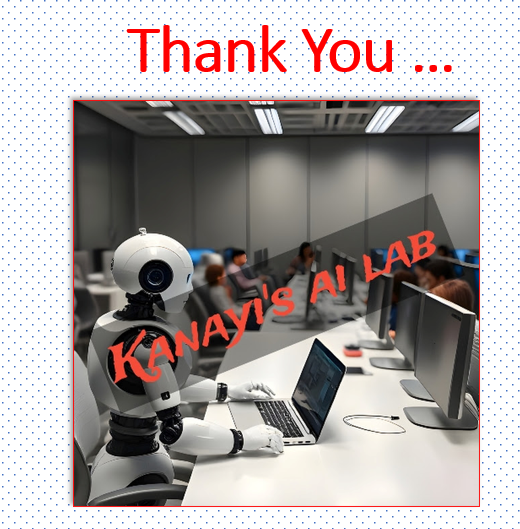